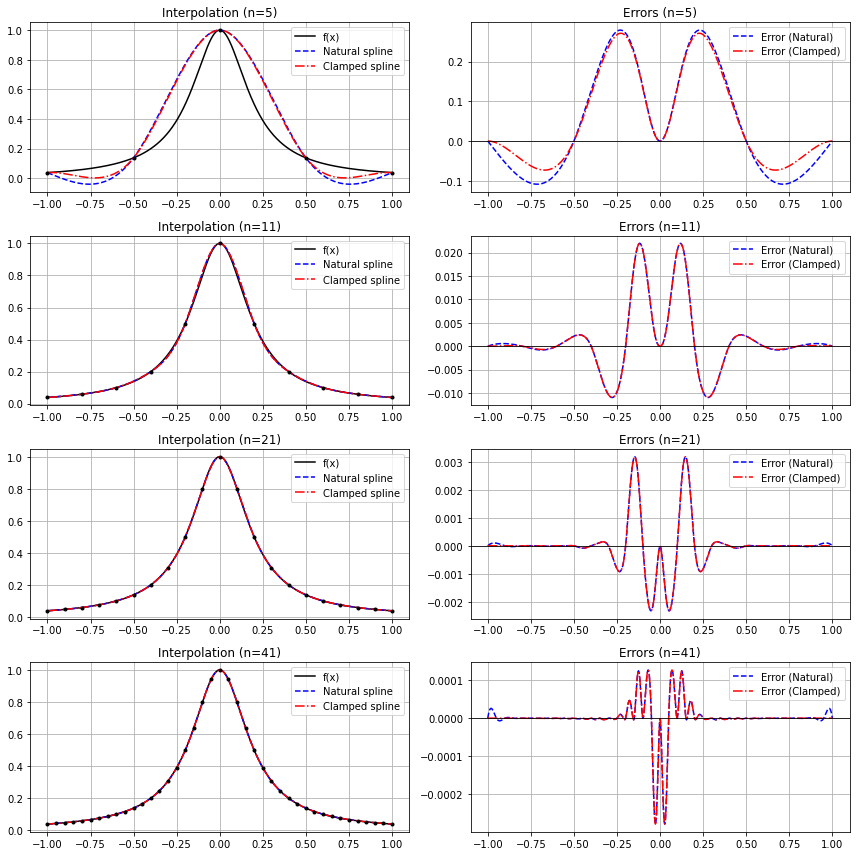

最小節點數 n 使得 ||f - natural spline||∞ ≤ 1e-10: 1000
最小節點數 n 使得 ||f - clamped spline||∞ ≤ 1e-10: 998
最小節點數 n 使得 ||f - Chebyshev||∞ ≤ 1e-10: 117


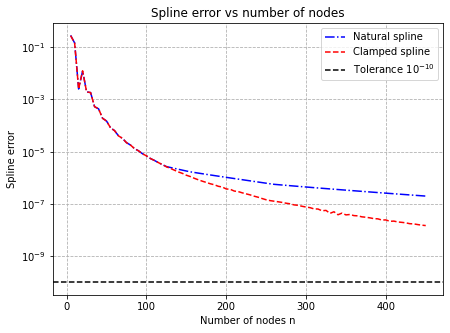

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, BarycentricInterpolator

# -------------------------------
# Function and derivative
# -------------------------------
def f(x):
    return 1 / (1 + 25 * x**2)

def f_prime(x):
    return -50 * x / (1 + 25 * x**2)**2

# Evaluation grid
x_plot = np.linspace(-1, 1, 1000)
y_true = f(x_plot)

# -------------------------------
# Part 1: Interpolations for selected n
# -------------------------------
N_list = [5, 11, 21, 41]

fig, axes = plt.subplots(len(N_list), 2, figsize=(12, 12))
for i, n in enumerate(N_list):
    x_nodes = np.linspace(-1, 1, n)
    y_nodes = f(x_nodes)

    # Natural spline
    cs_nat = CubicSpline(x_nodes, y_nodes, bc_type="natural")
    y_nat = cs_nat(x_plot)

    # Clamped spline
    cs_clamped = CubicSpline(x_nodes, y_nodes,
                             bc_type=((1, f_prime(x_nodes[0])),
                                      (1, f_prime(x_nodes[-1]))))
    y_clamped = cs_clamped(x_plot)

    # Plot interpolation
    axes[i,0].plot(x_plot, y_true, 'k-', label="f(x)")
    axes[i,0].plot(x_plot, y_nat, 'b--', label="Natural spline")
    axes[i,0].plot(x_plot, y_clamped, 'r-.', label="Clamped spline")
    axes[i,0].plot(x_nodes, y_nodes, 'ko', ms=3)
    axes[i,0].set_title(f"Interpolation (n={n})")
    axes[i,0].legend()
    axes[i,0].grid(True)

    # Plot errors
    axes[i,1].plot(x_plot, y_nat - y_true, 'b--', label="Error (Natural)")
    axes[i,1].plot(x_plot, y_clamped - y_true, 'r-.', label="Error (Clamped)")
    axes[i,1].axhline(0, color='k', lw=0.8)
    axes[i,1].set_title(f"Errors (n={n})")
    axes[i,1].legend()
    axes[i,1].grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# Part 2: Compute min nodes for tolerance
# -------------------------------
def spline_error(n):
    x_nodes = np.linspace(-1, 1, n)
    y_nodes = f(x_nodes)
    cs_nat = CubicSpline(x_nodes, y_nodes, bc_type="natural")
    y_nat = cs_nat(x_plot)
    cs_clamped = CubicSpline(x_nodes, y_nodes,
                             bc_type=((1, f_prime(x_nodes[0])),
                                      (1, f_prime(x_nodes[-1]))))
    y_clamped = cs_clamped(x_plot)
    return np.max(np.abs(y_nat - y_true)), np.max(np.abs(y_clamped - y_true))

def chebyshev_error(n):
    k = np.arange(n)
    x_nodes = np.cos((2*k+1)/(2*n)*np.pi)
    y_nodes = f(x_nodes)
    interp = BarycentricInterpolator(x_nodes, y_nodes)
    y_interp = interp(x_plot)
    return np.max(np.abs(y_interp - y_true))

tol = 1e-10
maxN_spline = 1500
maxN_cheb = 200

N_spline_nat, N_spline_clamped, N_cheb = None, None, None
for n in range(5, max(maxN_spline, maxN_cheb)+1):
    if n <= maxN_spline:
        err_nat, err_clamped = spline_error(n)
        if N_spline_nat is None and err_nat <= tol:
            N_spline_nat = n
        if N_spline_clamped is None and err_clamped <= tol:
            N_spline_clamped = n
    if n <= maxN_cheb:
        err_c = chebyshev_error(n)
        if N_cheb is None and err_c <= tol:
            N_cheb = n
    if N_spline_nat and N_spline_clamped and N_cheb:
        break

print(f"最小節點數 n 使得 ||f - natural spline||∞ ≤ 1e-10: {N_spline_nat}")
print(f"最小節點數 n 使得 ||f - clamped spline||∞ ≤ 1e-10: {N_spline_clamped}")
print(f"最小節點數 n 使得 ||f - Chebyshev||∞ ≤ 1e-10: {N_cheb}")

# -------------------------------
# Plot ∞-norm errors vs number of nodes (spline only, up to 250 nodes)
# -------------------------------
N_vals_spline = np.arange(5, 451, 5)  
errors_nat = []
errors_clamped = []

for n in N_vals_spline:
    err_nat, err_clamped = spline_error(n)
    errors_nat.append(err_nat)
    errors_clamped.append(err_clamped)

plt.figure(figsize=(7,5))
plt.semilogy(N_vals_spline, errors_nat, 'b-.', label='Natural spline')
plt.semilogy(N_vals_spline, errors_clamped, 'r--', label='Clamped spline')
plt.axhline(1e-10, color='k', linestyle='--', label=r'Tolerance $10^{-10}$')
plt.xlabel('Number of nodes n')
plt.ylabel('Spline error')
plt.title('Spline error vs number of nodes')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()
